<a href="https://colab.research.google.com/github/JannaBabicheva/Tour-region-econometrics/blob/main/2_%D0%91%D0%B0%D0%B1%D0%B8%D1%87%D0%B5%D0%B2%D0%B0_%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка библиотек

In [22]:
# Установка библиотек
!pip install pulp
!pip install statsmodels
!pip install scikit-learn
!pip install pandas numpy matplotlib
!pip install pysal
!pip install linearmodels
!pip install spreg
# Установка библиотек
!pip install pandas numpy matplotlib seaborn scipy statsmodels linearmodels libpysal spreg esda

# Подключение к диску

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Модели

## 1

# подготовка данных

In [ ]:
# Функции для подготовки данных

def calculate_vif(data):
    """Рассчитывает VIF для проверки мультиколлинеарности с константой."""
    X_vif = sm.add_constant(data)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    return vif_data

def fix_region_column(df):
    """Исправляет название столбца региона."""
    possible_region_names = ['Unnamed: 0', 'region', 'Region', 'REGION', 'RegionName', 'region_name']
    region_col = next((col for col in df.columns if col.lower().strip() in [name.lower() for name in possible_region_names]), None)
    if region_col:
        df = df.rename(columns={region_col: 'region'})
        print(f"Столбец '{region_col}' переименован в 'region'.")
    else:
        raise KeyError(f"Столбец с названием региона не найден в датафрейме: {df.columns.tolist()}")
    return df

def melt_dataframe(df, id_vars, value_name):
    """Преобразует датафрейм в длинный формат."""
    melt_cols = [col for col in df.columns if col not in id_vars]
    if not melt_cols:
        return df
    melted_df = pd.melt(df, id_vars=id_vars, value_vars=melt_cols, var_name='year', value_name=value_name)
    melted_df['year'] = pd.to_numeric(melted_df['year'], errors='coerce')
    return melted_df

In [ ]:
# Путь к файлам (замените на актуальный путь)
file_paths = "/content/drive/MyDrive/НИР МФТИ+РАНХиГС/"

# Загрузка данных
dataframes = [
    pd.read_excel(file_paths + "2/Число коллективных средств размещения.xlsx"),
    pd.read_excel(file_paths + "2/Число ночевок в коллективных средствах размещения (единица).xlsx"),
    pd.read_excel(file_paths + "2/средние цены на Проживание в гостинице, сутки с человека с 2003.xlsx"),
    pd.read_excel(file_paths + "3/salary_data_2003_2023.xlsx"),
    pd.read_excel(file_paths + "3/ВРП на душу населения.xlsx"),
    pd.read_excel(file_paths + "3/Инвестиции в основной капитал по субьектам РФ2003-2023 росстат.xlsx"),
    pd.read_excel(file_paths + "3/rooms.xlsx"),
    pd.read_excel(file_paths + "2/кол-во аэропортов по регионам.xlsx"),
    pd.read_excel(file_paths + "2/Численность постоянного населения в среднем за год (человек).xls"),
    pd.read_excel(file_paths + "2/уровень безработицы.xlsx"),
    pd.read_excel(file_paths + "2/цены на Дизельное топливо, л.xls"),
    pd.read_excel(file_paths + "2/averaged_train_costs_per_region_by_year (1).xlsx")
]

# Переименование столбца региона
for i in range(len(dataframes)):
    dataframes[i] = fix_region_column(dataframes[i])

# Присваивание переменным
hotels, nights, prices, salary, gdp, investments, rooms, airports_data, population, unemployment, diesel_data, train_cost_data = dataframes

In [ ]:
# Преобразование данных в длинный формат
dataframes_long = [
    melt_dataframe(hotels, ['region'], 'hotels_count'),
    melt_dataframe(nights, ['region'], 'nights_count'),
    melt_dataframe(prices, ['region'], 'price'),
    melt_dataframe(salary, ['region'], 'salary'),
    melt_dataframe(gdp, ['region'], 'gdp_per_capita'),
    melt_dataframe(investments, ['region'], 'investments'),
    melt_dataframe(rooms, ['region'], 'rooms_count'),
    melt_dataframe(airports_data, ['region'], 'airports_count'),
    melt_dataframe(population, ['region'], 'population'),
    melt_dataframe(unemployment, ['region'], 'unemployment'),
    melt_dataframe(diesel_data, ['region'], 'diesel_price'),
    melt_dataframe(train_cost_data, ['region'], 'train_cost')
]

# Объединение данных
data = dataframes_long[0]
for df in dataframes_long[1:]:
    data = pd.merge(data, df, on=['region', 'year'], how='left')

# Фильтрация по периоду 2003-2023
data = data[(data['year'] >= 2003) & (data['year'] <= 2023)]

In [ ]:
# Корректировка на инфляцию с базисным годом 2003
cpi_data_2003 = {
    2003: 100.00, 2004: 111.00, 2005: 122.10, 2006: 133.30, 2007: 145.10, 2008: 158.40,
    2009: 172.80, 2010: 183.90, 2011: 204.20, 2012: 214.50, 2013: 228.00,
    2014: 246.80, 2015: 267.80, 2016: 277.20, 2017: 281.80, 2018: 284.30,
    2019: 293.90, 2020: 300.20, 2021: 309.30, 2022: 327.00, 2023: 337.30
}
data['cpi'] = data['year'].map(cpi_data_2003)
for var in ['price', 'gdp_per_capita', 'salary', 'investments', 'train_cost', 'diesel_price']:
    data[f'{var}_adjusted'] = data[var] / (data['cpi'] / 100)

In [ ]:
# Преобразование и очистка данных

# Преобразование nights_count в числовой формат
data['nights_count'] = pd.to_numeric(data['nights_count'].astype(str).str.replace(' ', ''), errors='coerce')
data['nights_count'] = data['nights_count'].astype(float)
data.loc[data['nights_count'] == 0, 'nights_count'] = np.exp(13.464635).astype(float)

# Замена бесконечностей и пропусков медианой
for col in ['nights_count', 'price_adjusted', 'salary_adjusted', 'gdp_per_capita_adjusted', 'investments_adjusted',
            'population', 'diesel_price_adjusted', 'unemployment', 'train_cost_adjusted']:
    data[col] = data[col].replace([np.inf, -np.inf], np.nan).fillna(data[col].median())

# Исключение неменяющихся переменных
time_varying_vars = ['hotels_count', 'rooms_count', 'airports_count']
for var in time_varying_vars:
    if var in data.columns:
        variation = data.groupby('region')[var].nunique()
        if (variation == 1).all():
            data = data.drop(columns=[var])

# Логарифмирование переменных
vars_to_log = ['nights_count', 'price_adjusted', 'salary_adjusted', 'gdp_per_capita_adjusted', 'investments_adjusted',
               'population', 'diesel_price_adjusted', 'unemployment', 'train_cost_adjusted']
for var in vars_to_log:
    data[f'ln_{var}'] = np.log(data[var] + 1)

# Создание лагов
data = data.sort_values(['region', 'year'])
for var in ['nights_count', 'price_adjusted', 'salary_adjusted']:
    lag_col = f'ln_{var}_lag1'
    data[lag_col] = data.groupby('region')[f'ln_{var}'].shift(1)
    data[lag_col] = data[lag_col].fillna(data[lag_col].median())

# Синхронизация регионов
region_mapping = {
    'Москва': 'Город Москва столица Российской Федерации город федерального значения',
    'Краснодарский край': 'Краснодарский край',
    'Санкт-Петербург': 'Город Санкт-Петербург город федерального значения',
    'Ингушетия': 'Республика Ингушетия',
    'Чукотский АО': 'Чукотский автономный округ',
    'Московская область': 'Московская область'
}
data['region'] = data['region'].replace(region_mapping)

# Установка мультииндекса
data = data.set_index(['region', 'year'])

In [ ]:
# Удаление выбросов
z_scores = stats.zscore(data['ln_nights_count'])
data_clean = data[(z_scores < 3) & (z_scores > -3)].copy()
dependent_clean = data_clean['ln_nights_count']

# Стандартизация для снижения VIF
for var in ['ln_gdp_per_capita_adjusted', 'ln_population', 'ln_unemployment', 'ln_nights_count_lag1']:
    data_clean[var] = (data_clean[var] - data_clean[var].mean()) / data_clean[var].std()

# Модель (FE с лагом)

Строю модель PanelOLS с фиксированными эффектами и лаговой переменной ln_nights_count_lag1.

In [ ]:
# Модель 1: FE с лагом
exog_vars_lag = ['ln_nights_count_lag1']
exog_lag = data_clean[exog_vars_lag]
fe_lag_model = PanelOLS(dependent_clean, sm.add_constant(exog_lag), entity_effects=True, time_effects=True)
fe_lag_results = fe_lag_model.fit(cov_type='clustered', cluster_entity=True)
print("\nМодель 1: FE с лагом:")
print(fe_lag_results.summary)

R² (Within): 0.2342 — модель объясняет 23.42% внутрирегиональной вариации.

Коэффициентln_nights_count_lag1: 0.3493 (p = 0.0000) — значимый положительный эффект.

Дальнейшее действие: Строю модель IV-2SLS, чтобы учесть эндогенность цен (ln_price_adjusted).

Причина: Цены могут быть эндогенны, так как спрос и цены определяются одновременно.

есть подозрение на двустороннюю связь

# Модель (IV-2SLS)

Строю модель IV-2SLS, используя ln_price_adjusted как эндогенную переменную и ln_price_adjusted_lag1, ln_salary_adjusted_lag1 как инструменты. Проверяю валидность инструментов.

In [ ]:
# Модель 2: 2SLS с новым инструментом
exog_vars_2sls = ['ln_gdp_per_capita_adjusted', 'ln_population', 'ln_unemployment', 'ln_nights_count_lag1']
endog_var = ['ln_price_adjusted']
instrument_var = ['ln_price_adjusted_lag1', 'ln_salary_adjusted_lag1']
exog_2sls = data_clean[exog_vars_2sls]
endog_2sls = data_clean[endog_var]
instrument_2sls = data_clean[instrument_var]
iv_model = IV2SLS(dependent=dependent_clean, exog=sm.add_constant(exog_2sls), endog=endog_2sls, instruments=instrument_2sls)
iv_results = iv_model.fit(cov_type='robust')
print("\nМодель 2 (с новым инструментом ln_salary_adjusted_lag1):")
print(iv_results.summary)

# Проверка корреляции инструментов
for instr in instrument_var:
    corr = data_clean['ln_price_adjusted'].corr(data_clean[instr])
    print(f"Корреляция между ln_price_adjusted и {instr}: {corr:.4f}")

# Тест Сарджана
residuals_2sls = iv_results.resids
exog_sargan = sm.add_constant(data_clean[exog_vars_2sls + instrument_var])
sargan_reg = sm.OLS(residuals_2sls, exog_sargan).fit()
n = len(residuals_2sls)
sargan_stat = n * sargan_reg.rsquared
sargan_pvalue = 1 - stats.chi2.cdf(sargan_stat, df=2)  # df=2 для двух инструментов
print(f"\nТест Сарджана для Модели 2 (валидность инструментов):")
print(f"Statistic: {sargan_stat:.4f}, p-value: {sargan_pvalue:.4f}")
if sargan_pvalue > 0.05:
    print("Инструменты валидны (p-value > 0.05).")
else:
    print("Инструменты могут быть невалидными (p-value <= 0.05).")

# Тест слабых инструментов (F-статистика первой стадии)
exog_first_stage = sm.add_constant(data_clean[exog_vars_2sls + instrument_var])
first_stage = sm.OLS(endog_2sls, exog_first_stage).fit(cov_type='HC0')
f_stat = first_stage.fvalue
print(f"\nF-статистика первой стадии: {f_stat:.4f}")
if f_stat > 10:
    print("Инструменты достаточно сильны (F > 10).")
else:
    print("Инструменты могут быть слабыми (F <= 10).")

R²: 0.9404 — очень высокая объясняющая способность, но это может быть признаком переобучения.

Коэффициент ln_price_adjusted: -0.0510 (p = 0.0303) — значимый отрицательный эффект.

Инструменты валидны (тест Сарджана: p = 0.5274) и сильны (F-статистика: 121.4978).

Дальнейшее действие: Строю экономическую модель с фиксированными эффектами, чтобы проверить влияние экономических факторов.

Причина: Хочу оценить влияние ВРП, населения и безработицы без учёта эндогенности цен.

# Модель  (FE экономическая)

Строю модель PanelOLS с экономическими переменными и провожу тест Хаусмана для выбора между FE и RE.

In [ ]:
# Модель 3: FE экономическая
exog_vars_econ = ['ln_gdp_per_capita_adjusted', 'ln_population', 'ln_unemployment', 'ln_nights_count_lag1']
exog_econ = data_clean[exog_vars_econ]
fe_econ_model = PanelOLS(dependent_clean, sm.add_constant(exog_econ), entity_effects=True, time_effects=True)
fe_econ_results = fe_econ_model.fit(cov_type='clustered', cluster_entity=True)
print("\nМодель 3: FE экономическая:")
print(fe_econ_results.summary)

# Тест Хаусмана
re_econ_model = RandomEffects(dependent_clean, sm.add_constant(exog_econ))
re_econ_results = re_econ_model.fit()
coef_fe = fe_econ_results.params
coef_re = re_econ_results.params
var_fe = fe_econ_results.cov
var_re = re_econ_results.cov
diff_coef = coef_fe - coef_re
diff_var = var_fe - var_re
hausman_stat = diff_coef.T @ np.linalg.pinv(diff_var) @ diff_coef
df = len(exog_vars_econ)
hausman_pvalue = 1 - stats.chi2.cdf(hausman_stat, df)
print("\nТест Хаусмана (FE vs RE):")
print(f"Hausman Statistic: {hausman_stat:.4f}, p-value: {hausman_pvalue:.4f}")
if hausman_pvalue < 0.05:
    print("Отвергаем H0: фиксированные эффекты предпочтительнее случайных.")

R² (Within): 0.3096 — модель объясняет 30.96% внутрирегиональной вариации. Значимые переменные: ln_population (p = 0.0448), ln_nights_count_lag1 (p = 0.0003).

Тест Хаусмана подтверждает, что фиксированные эффекты предпочтительнее случайных (p = 0.0000).

Дальнейшее действие: Проверяю предсказательную способность Модели 3 с помощью кросс-валидации.

Причина: Хочу убедиться, что модель не переобучена и хорошо обобщает на новых данных.

# 2 вариант моделей

In [30]:
# Импорт библиотек
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Функции для подготовки данных
def calculate_vif(data):
    """Рассчитывает VIF для проверки мультиколлинеарности с константой."""
    X_vif = sm.add_constant(data)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    return vif_data

def fix_region_column(df):
    """Исправляет название столбца региона."""
    possible_region_names = ['Unnamed: 0', 'region', 'Region', 'REGION', 'RegionName', 'region_name']
    region_col = next((col for col in df.columns if col.lower().strip() in [name.lower() for name in possible_region_names]), None)
    if region_col:
        df = df.rename(columns={region_col: 'region'})
        print(f"Столбец '{region_col}' переименован в 'region'.")
    else:
        raise KeyError(f"Столбец с названием региона не найден в датафрейме: {df.columns.tolist()}")
    return df

def melt_dataframe(df, id_vars, value_name):
    """Преобразует датафрейм в длинный формат."""
    melt_cols = [col for col in df.columns if col not in id_vars]
    if not melt_cols:
        return df
    melted_df = pd.melt(df, id_vars=id_vars, value_vars=melt_cols, var_name='year', value_name=value_name)
    melted_df['year'] = pd.to_numeric(melted_df['year'], errors='coerce')
    return melted_df

# Загрузка данных
file_paths = "/content/drive/MyDrive/НИР МФТИ+РАНХиГС/"

dataframes = [
    pd.read_excel(file_paths + "2/Число коллективных средств размещения.xlsx"),
    pd.read_excel(file_paths + "2/Число ночевок в коллективных средствах размещения (единица).xlsx"),
    pd.read_excel(file_paths + "2/средние цены на Проживание в гостинице, сутки с человека с 2003.xlsx"),
    pd.read_excel(file_paths + "3/salary_data_2003_2023.xlsx"),
    pd.read_excel(file_paths + "3/ВРП на душу населения.xlsx"),
    pd.read_excel(file_paths + "3/Инвестиции в основной капитал по субьектам РФ2003-2023 росстат.xlsx"),
    pd.read_excel(file_paths + "3/rooms.xlsx"),
    pd.read_excel(file_paths + "2/кол-во аэропортов по регионам.xlsx"),
    pd.read_excel(file_paths + "2/Численность постоянного населения в среднем за год (человек).xls"),
    pd.read_excel(file_paths + "2/уровень безработицы.xlsx"),
    pd.read_excel(file_paths + "2/цены на Дизельное топливо, л.xls"),
    pd.read_excel(file_paths + "2/averaged_train_costs_per_region_by_year (1).xlsx")
]

# Переименование столбца региона
for i in range(len(dataframes)):
    dataframes[i] = fix_region_column(dataframes[i])

hotels, nights, prices, salary, gdp, investments, rooms, airports_data, population, unemployment, diesel_data, train_cost_data = dataframes

# Преобразование данных в длинный формат
dataframes_long = [
    melt_dataframe(hotels, ['region'], 'hotels_count'),
    melt_dataframe(nights, ['region'], 'nights_count'),
    melt_dataframe(prices, ['region'], 'price'),
    melt_dataframe(salary, ['region'], 'salary'),
    melt_dataframe(gdp, ['region'], 'gdp_per_capita'),
    melt_dataframe(investments, ['region'], 'investments'),
    melt_dataframe(rooms, ['region'], 'rooms_count'),
    melt_dataframe(airports_data, ['region'], 'airports_count'),
    melt_dataframe(population, ['region'], 'population'),
    melt_dataframe(unemployment, ['region'], 'unemployment'),
    melt_dataframe(diesel_data, ['region'], 'diesel_price'),
    melt_dataframe(train_cost_data, ['region'], 'train_cost')
]

# Объединение данных
data = dataframes_long[0]
for df in dataframes_long[1:]:
    data = pd.merge(data, df, on=['region', 'year'], how='left')

# Фильтрация по периоду 2003-2023
data = data[(data['year'] >= 2003) & (data['year'] <= 2023)]

# Корректировка на инфляцию
cpi_data_2003 = {
    2003: 100.00, 2004: 111.00, 2005: 122.10, 2006: 133.30, 2007: 145.10, 2008: 158.40,
    2009: 172.80, 2010: 183.90, 2011: 204.12, 2012: 214.50, 2013: 228.00,
    2014: 246.80, 2015: 267.60, 2016: 277.20, 2017: 281.80, 2018: 284.30,
    2019: 293.90, 2020: 300.20, 2021: 309.30, 2022: 327.00, 2023: 337.30
}
data['cpi'] = data['year'].map(cpi_data_2003)
for var in ['price', 'gdp_per_capita', 'salary', 'investments', 'train_cost', 'diesel_price']:
    data[f'{var}_adjusted'] = data[var] / (data['cpi'] / 100)

# Преобразование и очистка данных
data['nights_count'] = pd.to_numeric(data['nights_count'].astype(str).str.replace(' ', ''), errors='coerce')
data['nights_count'] = data['nights_count'].astype(float)
data.loc[data['nights_count'] == 0, 'nights_count'] = np.exp(13.464635).astype(float)

# Замена бесконечностей и пропусков медианой
for col in ['nights_count', 'price_adjusted', 'salary_adjusted', 'gdp_per_capita_adjusted', 'investments_adjusted',
            'population', 'diesel_price_adjusted', 'unemployment', 'train_cost_adjusted']:
    data[col] = data[col].replace([np.inf, -np.inf], np.nan).fillna(data[col].median())

# Исключение неменяющихся переменных
time_varying_vars = ['hotels_count', 'rooms_count', 'airports_count']
for var in time_varying_vars:
    if var in data.columns:
        variation = data.groupby('region')[var].nunique()
        if (variation == 1).all():
            data = data.drop(columns=[var])

# Логарифмирование переменных (уже применено ранее)
vars_to_log = ['nights_count', 'price_adjusted', 'salary_adjusted', 'gdp_per_capita_adjusted', 'investments_adjusted',
               'population', 'diesel_price_adjusted', 'unemployment', 'train_cost_adjusted']
for var in vars_to_log:
    data[f'ln_{var}'] = np.log(data[var] + 1)

# Создание лагов первого и второго порядка
data = data.sort_values(['region', 'year'])
for var in ['nights_count', 'price_adjusted', 'salary_adjusted']:
    lag1_col = f'ln_{var}_lag1'
    lag2_col = f'ln_{var}_lag2'
    data[lag1_col] = data.groupby('region')[f'ln_{var}'].shift(1)
    data[lag2_col] = data.groupby('region')[f'ln_{var}'].shift(2)
    data[lag1_col] = data[lag1_col].fillna(data[lag1_col].median())
    data[lag2_col] = data[lag2_col].fillna(data[lag2_col].median())

# Синхронизация регионов
region_mapping = {
    'Москва': 'Город Москва столица Российской Федерации город федерального значения',
    'Краснодарский край': 'Краснодарский край',
    'Санкт-Петербург': 'Город Санкт-Петербург город федерального значения',
    'Ингушетия': 'Республика Ингушетия',
    'Чукотский АО': 'Чукотский автономный округ',
    'Московская область': 'Московская область'
}
data['region'] = data['region'].replace(region_mapping)

# Установка мультииндекса
data = data.set_index(['region', 'year'])

# Удаление выбросов и стандартизация
z_scores = stats.zscore(data['ln_nights_count'])
data_clean = data[(z_scores < 1.5) & (z_scores > -1.5)].copy()

# Стандартизация переменных (линейное преобразование)
for var in ['ln_gdp_per_capita_adjusted', 'ln_population', 'ln_unemployment', 'ln_nights_count_lag1', 'ln_nights_count_lag2',
            'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']:
    data_clean[var] = (data_clean[var] - data_clean[var].mean()) / data_clean[var].std()

# Разделение данных на тренировочные (2003–2020) и тестовые (2021–2023)
train_data = data_clean[data_clean.index.get_level_values('year') <= 2020].copy()
test_data = data_clean[data_clean.index.get_level_values('year') > 2020].copy()
print(f"Размер тренировочной выборки (z < 1.5, 2003–2020): {len(train_data)}")
print(f"Размер тестовой выборки (z < 1.5, 2021–2023): {len(test_data)}")

# Проверка мультиколлинеарности
exog_vars_fe = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted', 'ln_population',
                'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
vif_data = calculate_vif(train_data[exog_vars_fe])
print("\nVIF для экзогенных переменных:")
print(vif_data)

# Модель 1: PanelOLS с фиксированными эффектами
exog_fe = train_data[exog_vars_fe]
fe_model = PanelOLS(train_data['ln_nights_count'], sm.add_constant(exog_fe),
                    entity_effects=True, time_effects=True, drop_absorbed=True)
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)

# Вывод результатов модели
print("\nМодель 1: PanelOLS с фиксированными эффектами:")
print(fe_results.summary)

# Предсказания на тестовом наборе
test_exog_fe = sm.add_constant(test_data[exog_vars_fe])
test_pred_fe = fe_results.predict(test_exog_fe)
test_pred_fe = test_pred_fe.iloc[:, 0]
test_pred_fe = pd.Series(test_pred_fe, index=test_data.index)

# Вычисление R²
ss_total_fe = np.sum((test_data['ln_nights_count'] - test_data['ln_nights_count'].mean())**2)
ss_residual_fe = np.sum((test_data['ln_nights_count'] - test_pred_fe)**2)
r2_test_fe = 1 - ss_residual_fe / ss_total_fe
print(f"\nR² на тестовой выборке для Модели 1: {r2_test_fe:.4f}")

# Модель 2: IV-2SLS с фиктивными переменными для регионов и годов
train_data_reset = train_data.reset_index()
test_data_reset = test_data.reset_index()
train_data_dummy = pd.get_dummies(train_data_reset, columns=['region', 'year'], drop_first=True)
test_data_dummy = pd.get_dummies(test_data_reset, columns=['region', 'year'], drop_first=True)

# Убедимся, что столбцы совпадают в train и test
missing_cols = set(train_data_dummy.columns) - set(test_data_dummy.columns)
for col in missing_cols:
    test_data_dummy[col] = 0
test_data_dummy = test_data_dummy[train_data_dummy.columns]

# Переменные для IV-2SLS
exog_vars_2sls = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted', 'ln_population',
                  'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
endog_var = ['ln_price_adjusted']
instrument_var = ['ln_price_adjusted_lag1', 'ln_price_adjusted_lag2', 'ln_salary_adjusted_lag1', 'ln_salary_adjusted_lag2']
dummy_vars = [col for col in train_data_dummy.columns if col.startswith('region_') or col.startswith('year_')]
exog_2sls = train_data_dummy[exog_vars_2sls + dummy_vars]
endog_2sls = train_data_dummy[endog_var]
instrument_2sls = train_data_dummy[instrument_var]

# Проверка мультиколлинеарности для первой стадии
first_stage_vars = exog_vars_2sls + instrument_var
vif_first_stage = calculate_vif(train_data_dummy[first_stage_vars])
print("\nVIF для первой стадии IV-2SLS:")
print(vif_first_stage)

# Построение модели
iv_model = IV2SLS(dependent=train_data_dummy['ln_nights_count'], exog=sm.add_constant(exog_2sls),
                  endog=endog_2sls, instruments=instrument_2sls)
iv_results = iv_model.fit(cov_type='robust')

# Вывод результатов
print("\nМодель 2: IV-2SLS с учётом эндогенности цен:")
print(iv_results.summary)

# Предсказания для тестового набора
test_exog_2sls = test_data_dummy[exog_vars_2sls + dummy_vars]
test_endog_2sls = test_data_dummy[endog_var]
test_pred_2sls = iv_results.predict(exog=sm.add_constant(test_exog_2sls), endog=test_endog_2sls)
test_pred_2sls = test_pred_2sls.to_numpy().flatten()

# Вычисление R²
ss_total_2sls = np.sum((test_data_dummy['ln_nights_count'] - test_data_dummy['ln_nights_count'].mean())**2)
ss_residual_2sls = np.sum((test_data_dummy['ln_nights_count'] - test_pred_2sls)**2)
r2_test_2sls = 1 - ss_residual_2sls / ss_total_2sls
print(f"\nR² на тестовой выборке для Модели 2: {r2_test_2sls:.4f}")

# Модель в первой разности (PanelOLS)
data_diff = data_clean.sort_values(['region', 'year']).copy()
data_diff['ln_nights_count_diff'] = data_diff.groupby('region')['ln_nights_count'].diff()

# Удаление строк с NA (первые годы каждого региона)
data_diff = data_diff.dropna(subset=['ln_nights_count_diff'])

# Проверка на аномалии в разностях
z_scores_diff = stats.zscore(data_diff['ln_nights_count_diff'].values)
print("\nПроверка на аномалии в разностях (z-scores > 3):")
print(data_diff[z_scores_diff > 3][['ln_nights_count_diff']])  # Положительные аномалии
print(data_diff[z_scores_diff < -3][['ln_nights_count_diff']])  # Отрицательные аномалии

# Фильтрация аномалий (линейное удаление)
data_diff_clean = data_diff[(z_scores_diff.abs() <= 3)].copy()

# Модель в первой разности с полным набором переменных
exog_diff = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted', 'ln_population',
             'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
diff_model = PanelOLS(data_diff_clean['ln_nights_count_diff'], sm.add_constant(data_diff_clean[exog_diff]),
                      entity_effects=True, time_effects=True, drop_absorbed=True)
diff_results = diff_model.fit(cov_type='clustered', cluster_entity=True)

print("\nМодель в первой разности (PanelOLS) с полным набором переменных:")
print(diff_results.summary)

# Рекомендация 1: Модель в разностях только с ln_nights_count_lag1
exog_diff_simple = ['ln_nights_count_lag1']
diff_model_simple = PanelOLS(data_diff_clean['ln_nights_count_diff'], sm.add_constant(data_diff_clean[exog_diff_simple]),
                             entity_effects=True, time_effects=True, drop_absorbed=True)
diff_results_simple = diff_model_simple.fit(cov_type='clustered', cluster_entity=True)
print("\nМодель в первой разности (PanelOLS) только с ln_nights_count_lag1:")
print(diff_results_simple.summary)

# Рекомендация 2: IV-2SLS в разностях
train_data_diff = data_diff_clean[data_diff_clean.index.get_level_values('year') <= 2020].copy()
test_data_diff = data_diff_clean[data_diff_clean.index.get_level_values('year') > 2020].copy()

train_data_diff_reset = train_data_diff.reset_index()
test_data_diff_reset = test_data_diff.reset_index()
train_data_diff_dummy = pd.get_dummies(train_data_diff_reset, columns=['region', 'year'], drop_first=True)
test_data_diff_dummy = pd.get_dummies(test_data_diff_reset, columns=['region', 'year'], drop_first=True)

# Убедимся, что столбцы совпадают
missing_cols_diff = set(train_data_diff_dummy.columns) - set(test_data_diff_dummy.columns)
for col in missing_cols_diff:
    test_data_diff_dummy[col] = 0
test_data_diff_dummy = test_data_diff_dummy[train_data_diff_dummy.columns]

# Переменные для IV-2SLS в разностях
exog_vars_2sls_diff = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted', 'ln_population',
                       'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
endog_var_diff = ['ln_price_adjusted']
instrument_var_diff = ['ln_price_adjusted_lag1', 'ln_price_adjusted_lag2', 'ln_salary_adjusted_lag1', 'ln_salary_adjusted_lag2']
dummy_vars_diff = [col for col in train_data_diff_dummy.columns if col.startswith('region_') or col.startswith('year_')]
exog_2sls_diff = train_data_diff_dummy[exog_vars_2sls_diff + dummy_vars_diff]
endog_2sls_diff = train_data_diff_dummy[endog_var_diff]
instrument_2sls_diff = train_data_diff_dummy[instrument_var_diff]

# Построение IV-2SLS в разностях
iv_model_diff = IV2SLS(dependent=train_data_diff_dummy['ln_nights_count_diff'], exog=sm.add_constant(exog_2sls_diff),
                       endog=endog_2sls_diff, instruments=instrument_2sls_diff)
iv_results_diff = iv_model_diff.fit(cov_type='robust')

print("\nМодель IV-2SLS в первой разности:")
print(iv_results_diff.summary)

# Диагностика остатков
residuals_fe = fe_results.resids
residuals_2sls = iv_results.resids
residuals_diff = diff_results.resids
residuals_diff_simple = diff_results_simple.resids
residuals_iv_diff = iv_results_diff.resids

# Добавлено: Логарифмирование остатков
residuals_fe_log = np.log(residuals_fe.abs() + 1)
residuals_2sls_log = np.log(residuals_2sls.abs() + 1)
residuals_diff_log = np.log(residuals_diff.abs() + 1)
residuals_diff_simple_log = np.log(residuals_diff_simple.abs() + 1)
residuals_iv_diff_log = np.log(residuals_iv_diff.abs() + 1)

# Тест Шапиро-Уилка для логарифмированных остатков
stat_fe, p_fe = stats.shapiro(residuals_fe_log)
stat_2sls, p_2sls = stats.shapiro(residuals_2sls_log)
stat_diff, p_diff = stats.shapiro(residuals_diff_log)
stat_diff_simple, p_diff_simple = stats.shapiro(residuals_diff_simple_log)
stat_iv_diff, p_iv_diff = stats.shapiro(residuals_iv_diff_log)

print("\nТест Шапиро-Уилка для логарифмированных остатков:")
print(f"Модель 1 (PanelOLS): Statistic={stat_fe:.4f}, p-value={p_fe:.4f}")
print(f"Модель 2 (IV-2SLS): Statistic={stat_2sls:.4f}, p-value={p_2sls:.4f}")
print(f"Модель Diff (PanelOLS): Statistic={stat_diff:.4f}, p-value={p_diff:.4f}")
print(f"Модель Diff Simple (PanelOLS): Statistic={stat_diff_simple:.4f}, p-value={p_diff_simple:.4f}")
print(f"Модель IV Diff (IV-2SLS): Statistic={stat_iv_diff:.4f}, p-value={p_iv_diff:.4f}")

# Тест Бройша-Пагана для Модели 1
X_fe = sm.add_constant(train_data[exog_vars_fe])
model_ols_fe = sm.OLS(train_data['ln_nights_count'], X_fe).fit()
residuals_ols_fe = model_ols_fe.resid
bp_test_fe = het_breuschpagan(residuals_ols_fe, X_fe)
labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
print("\nТест Бройша-Пагана для Модели 1:")
print(dict(zip(labels, bp_test_fe)))
if bp_test_fe[1] < 0.05:
    print("Гетероскедастичность присутствует (p-value < 0.05).")
else:
    print("Гетероскедастичность отсутствует (p-value >= 0.05).")

# Тест Дарбина-Уотсона
dw_stat_fe = durbin_watson(residuals_fe)
dw_stat_2sls = durbin_watson(residuals_2sls)
dw_stat_diff = durbin_watson(residuals_diff)
dw_stat_diff_simple = durbin_watson(residuals_diff_simple)
dw_stat_iv_diff = durbin_watson(residuals_iv_diff)

print(f"\nТест Дарбина-Уотсона для Модели 1: {dw_stat_fe:.4f}")
print(f"Тест Дарбина-Уотсона для Модели 2: {dw_stat_2sls:.4f}")
print(f"Тест Дарбина-Уотсона для Модели Diff: {dw_stat_diff:.4f}")
print(f"Тест Дарбина-Уотсона для Модели Diff Simple: {dw_stat_diff_simple:.4f}")
print(f"Тест Дарбина-Уотсона для Модели IV Diff: {dw_stat_iv_diff:.4f}")
if 1.5 <= dw_stat_fe <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели 1.")
if 1.5 <= dw_stat_2sls <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели 2.")
if 1.5 <= dw_stat_diff <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели Diff.")
if 1.5 <= dw_stat_diff_simple <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели Diff Simple.")
if 1.5 <= dw_stat_iv_diff <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели IV Diff.")

Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'region' переименован в 'region'.
Столбец 'Region' переименован в 'region'.
Размер тренировочной выборки (z < 1.5, 2003–2020): 1279
Размер тестовой выборки (z < 1.5, 2021–2023): 212

VIF для экзогенных переменных:
                     Variable        VIF
0                       const   1.108787
1        ln_nights_count_lag1  12.812720
2        ln_nights_count_lag2  10.862729
3  ln_gdp_per_capita_adjusted   1.523741
4               ln_population   3.080455
5             ln_unemployment   1.856850
6    ln_diesel_price_adjusted   1.503152
7      ln_train_cost_adjusted 

AttributeError: 'numpy.ndarray' object has no attribute 'abs'

In [31]:
# Импорт библиотек
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

# Предположим, что данные уже подготовлены и находятся в data_diff
# Создание разностей (если еще не сделано)
data_diff = data.sort_values(['region', 'year']).copy()
data_diff['ln_nights_count_diff'] = data_diff.groupby('region')['ln_nights_count'].diff()

# Удаление строк с NA (первые годы каждого региона)
data_diff = data_diff.dropna(subset=['ln_nights_count_diff'])

# Проверка на аномалии в разностях
z_scores_diff = stats.zscore(data_diff['ln_nights_count_diff'].values)
print("\nПроверка на аномалии в разностях (z-scores > 3):")
print(data_diff[z_scores_diff > 3][['ln_nights_count_diff']])  # Положительные аномалии
print(data_diff[z_scores_diff < -3][['ln_nights_count_diff']])  # Отрицательные аномалии

# Фильтрация аномалий (линейное удаление)
data_diff_clean = data_diff[np.abs(z_scores_diff) <= 3].copy()

# Модель в первой разности с полным набором переменных
exog_diff = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted', 'ln_population',
             'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
diff_model = PanelOLS(data_diff_clean['ln_nights_count_diff'], sm.add_constant(data_diff_clean[exog_diff]),
                      entity_effects=True, time_effects=True, drop_absorbed=True)
diff_results = diff_model.fit(cov_type='clustered', cluster_entity=True)

print("\nМодель в первой разности (PanelOLS) с полным набором переменных:")
print(diff_results.summary)

# Рекомендация 1: Модель в разностях только с ln_nights_count_lag1
exog_diff_simple = ['ln_nights_count_lag1']
diff_model_simple = PanelOLS(data_diff_clean['ln_nights_count_diff'], sm.add_constant(data_diff_clean[exog_diff_simple]),
                             entity_effects=True, time_effects=True, drop_absorbed=True)
diff_results_simple = diff_model_simple.fit(cov_type='clustered', cluster_entity=True)
print("\nМодель в первой разности (PanelOLS) только с ln_nights_count_lag1:")
print(diff_results_simple.summary)

# Рекомендация 2: IV-2SLS в разностях
train_data_diff = data_diff_clean[data_diff_clean.index.get_level_values('year') <= 2020].copy()
test_data_diff = data_diff_clean[data_diff_clean.index.get_level_values('year') > 2020].copy()

train_data_diff_reset = train_data_diff.reset_index()
test_data_diff_reset = test_data_diff.reset_index()
train_data_diff_dummy = pd.get_dummies(train_data_diff_reset, columns=['region', 'year'], drop_first=True)
test_data_diff_dummy = pd.get_dummies(test_data_diff_reset, columns=['region', 'year'], drop_first=True)

# Убедимся, что столбцы совпадают
missing_cols_diff = set(train_data_diff_dummy.columns) - set(test_data_diff_dummy.columns)
for col in missing_cols_diff:
    test_data_diff_dummy[col] = 0
test_data_diff_dummy = test_data_diff_dummy[train_data_diff_dummy.columns]

# Переменные для IV-2SLS в разностях
exog_vars_2sls_diff = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted', 'ln_population',
                       'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
endog_var_diff = ['ln_price_adjusted']
instrument_var_diff = ['ln_price_adjusted_lag1', 'ln_price_adjusted_lag2', 'ln_salary_adjusted_lag1', 'ln_salary_adjusted_lag2']
dummy_vars_diff = [col for col in train_data_diff_dummy.columns if col.startswith('region_') or col.startswith('year_')]
exog_2sls_diff = train_data_diff_dummy[exog_vars_2sls_diff + dummy_vars_diff]
endog_2sls_diff = train_data_diff_dummy[endog_var_diff]
instrument_2sls_diff = train_data_diff_dummy[instrument_var_diff]

# Построение IV-2SLS в разностях
iv_model_diff = IV2SLS(dependent=train_data_diff_dummy['ln_nights_count_diff'], exog=sm.add_constant(exog_2sls_diff),
                       endog=endog_2sls_diff, instruments=instrument_2sls_diff)
iv_results_diff = iv_model_diff.fit(cov_type='robust')

print("\nМодель IV-2SLS в первой разности:")
print(iv_results_diff.summary)

# Диагностика остатков
residuals_diff = diff_results.resids
residuals_diff_simple = diff_results_simple.resids
residuals_iv_diff = iv_results_diff.resids

# Добавлено: Логарифмирование остатков
residuals_diff_log = np.log(np.abs(residuals_diff) + 1)
residuals_diff_simple_log = np.log(np.abs(residuals_diff_simple) + 1)
residuals_iv_diff_log = np.log(np.abs(residuals_iv_diff) + 1)

# Тест Шапиро-Уилка для логарифмированных остатков
stat_diff, p_diff = stats.shapiro(residuals_diff_log)
stat_diff_simple, p_diff_simple = stats.shapiro(residuals_diff_simple_log)
stat_iv_diff, p_iv_diff = stats.shapiro(residuals_iv_diff_log)

print("\nТест Шапиро-Уилка для логарифмированных остатков:")
print(f"Модель Diff (PanelOLS): Statistic={stat_diff:.4f}, p-value={p_diff:.4f}")
print(f"Модель Diff Simple (PanelOLS): Statistic={stat_diff_simple:.4f}, p-value={p_diff_simple:.4f}")
print(f"Модель IV Diff (IV-2SLS): Statistic={stat_iv_diff:.4f}, p-value={p_iv_diff:.4f}")

# Тест Дарбина-Уотсона
dw_stat_diff = durbin_watson(residuals_diff)
dw_stat_diff_simple = durbin_watson(residuals_diff_simple)
dw_stat_iv_diff = durbin_watson(residuals_iv_diff)

print(f"\nТест Дарбина-Уотсона для Модели Diff: {dw_stat_diff:.4f}")
print(f"Тест Дарбина-Уотсона для Модели Diff Simple: {dw_stat_diff_simple:.4f}")
print(f"Тест Дарбина-Уотсона для Модели IV Diff: {dw_stat_iv_diff:.4f}")
if 1.5 <= dw_stat_diff <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели Diff.")
if 1.5 <= dw_stat_diff_simple <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели Diff Simple.")
if 1.5 <= dw_stat_iv_diff <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели IV Diff.")


Проверка на аномалии в разностях (z-scores > 3):
                           ln_nights_count_diff
region               year                      
Республика Ингушетия 2007              2.839685
                     2011              1.019460
Республика Калмыкия  2005              1.089731
Чеченская Республика 2009              1.207045
                     2013              3.686787
                           ln_nights_count_diff
region               year                      
Республика Ингушетия 2006             -2.300744
                     2010             -1.073472
Чеченская Республика 2006             -7.903955
                     2012             -1.104240

Модель в первой разности (PanelOLS) с полным набором переменных:
                           PanelOLS Estimation Summary                            
Dep. Variable:     ln_nights_count_diff   R-squared:                        0.0763
Estimator:                     PanelOLS   R-squared (Between):             -77.012
No. Observa

пересчитаем модели с фильтрацией аномалий (|z| ≤ 3), удалив строки для Чеченской Республики за 2006 и 2013 годы, где значения разностей ln_nights_count_diff составляют -7.903955 и 3.686787 соответственно. Также сохраним логарифмирование остатков для диагностики (помечено как # Добавлено: Логарифмирование остатков).

В Чечне в 2006 году произошло несколько значимых событий, в том числе уничтожение Шамиля Басаева в июле. В 2013 году продолжалась ситуация с незаконной торговлей оружием и наркотиками.
Более подробно:
2006 год:
Уничтожение Шамиля Басаева:
В июле 2006 года в результате спецоперации российских спецслужб был уничтожен лидер сепаратистов Шамиль Басаев.
Проблемы с внутренне перемещенными лицами:
На территории Чечни все еще оставалось большое количество внутренне перемещенных лиц, проживающих в плохих условиях.
Ограничения деятельности НПО:
Деятельность иностранных неправительственных организаций была сильно ограничена правительством Чечни.
2013 год:
Продолжающаяся незаконная торговля: Незаконная торговля оружием и наркотиками оставалась актуальной проблемой, несмотря на проводимые операции.
В целом:
2006 и 2013 годы были периодами с определенной динамикой в Чечне, связанной с последствиями вооруженного конфликта и продолжавшейся дестабилизацией ситуации.

In [29]:
# Импорт библиотек
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.iv import IV2SLS
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

# Предположим, что data_diff уже содержит разности
# Проверка на аномалии в разностях (уже выполнена ранее, используем результаты)
z_scores_diff = stats.zscore(data_diff['ln_nights_count_diff'].values)

# Фильтрация аномалий с порогом |z| <= 3
data_diff_clean = data_diff[np.abs(z_scores_diff) <= 3].copy()
print(f"Размер выборки после фильтрации аномалий: {len(data_diff_clean)}")

# Модель в первой разности с полным набором переменных
exog_diff = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted', 'ln_population',
             'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
diff_model = PanelOLS(data_diff_clean['ln_nights_count_diff'], sm.add_constant(data_diff_clean[exog_diff]),
                      entity_effects=True, time_effects=True, drop_absorbed=True)
diff_results = diff_model.fit(cov_type='clustered', cluster_entity=True)

print("\nМодель в первой разности (PanelOLS) с полным набором переменных после фильтрации:")
print(diff_results.summary)

# Модель в разностях только с ln_nights_count_lag1
exog_diff_simple = ['ln_nights_count_lag1']
diff_model_simple = PanelOLS(data_diff_clean['ln_nights_count_diff'], sm.add_constant(data_diff_clean[exog_diff_simple]),
                             entity_effects=True, time_effects=True, drop_absorbed=True)
diff_results_simple = diff_model_simple.fit(cov_type='clustered', cluster_entity=True)
print("\nМодель в первой разности (PanelOLS) только с ln_nights_count_lag1 после фильтрации:")
print(diff_results_simple.summary)

# IV-2SLS в разностях
train_data_diff = data_diff_clean[data_diff_clean.index.get_level_values('year') <= 2020].copy()
test_data_diff = data_diff_clean[data_diff_clean.index.get_level_values('year') > 2020].copy()

train_data_diff_reset = train_data_diff.reset_index()
test_data_diff_reset = test_data_diff.reset_index()
train_data_diff_dummy = pd.get_dummies(train_data_diff_reset, columns=['region', 'year'], drop_first=True)
test_data_diff_dummy = pd.get_dummies(test_data_diff_reset, columns=['region', 'year'], drop_first=True)

# Убедимся, что столбцы совпадают
missing_cols_diff = set(train_data_diff_dummy.columns) - set(test_data_diff_dummy.columns)
for col in missing_cols_diff:
    test_data_diff_dummy[col] = 0
test_data_diff_dummy = test_data_diff_dummy[train_data_diff_dummy.columns]

# Переменные для IV-2SLS в разностях
exog_vars_2sls_diff = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted', 'ln_population',
                       'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
endog_var_diff = ['ln_price_adjusted']
instrument_var_diff = ['ln_price_adjusted_lag1', 'ln_price_adjusted_lag2', 'ln_salary_adjusted_lag1', 'ln_salary_adjusted_lag2']
dummy_vars_diff = [col for col in train_data_diff_dummy.columns if col.startswith('region_') or col.startswith('year_')]
exog_2sls_diff = train_data_diff_dummy[exog_vars_2sls_diff + dummy_vars_diff]
endog_2sls_diff = train_data_diff_dummy[endog_var_diff]
instrument_2sls_diff = train_data_diff_dummy[instrument_var_diff]

# Построение IV-2SLS в разностях
iv_model_diff = IV2SLS(dependent=train_data_diff_dummy['ln_nights_count_diff'], exog=sm.add_constant(exog_2sls_diff),
                       endog=endog_2sls_diff, instruments=instrument_2sls_diff)
iv_results_diff = iv_model_diff.fit(cov_type='robust')

print("\nМодель IV-2SLS в первой разности после фильтрации:")
print(iv_results_diff.summary)

# Диагностика остатков
residuals_diff = diff_results.resids
residuals_diff_simple = diff_results_simple.resids
residuals_iv_diff = iv_results_diff.resids

# Добавлено: Логарифмирование остатков
residuals_diff_log = np.log(np.abs(residuals_diff) + 1)
residuals_diff_simple_log = np.log(np.abs(residuals_diff_simple) + 1)
residuals_iv_diff_log = np.log(np.abs(residuals_iv_diff) + 1)

# Тест Шапиро-Уилка для логарифмированных остатков
stat_diff, p_diff = stats.shapiro(residuals_diff_log)
stat_diff_simple, p_diff_simple = stats.shapiro(residuals_diff_simple_log)
stat_iv_diff, p_iv_diff = stats.shapiro(residuals_iv_diff_log)

print("\nТест Шапиро-Уилка для логарифмированных остатков после фильтрации:")
print(f"Модель Diff (PanelOLS): Statistic={stat_diff:.4f}, p-value={p_diff:.4f}")
print(f"Модель Diff Simple (PanelOLS): Statistic={stat_diff_simple:.4f}, p-value={p_diff_simple:.4f}")
print(f"Модель IV Diff (IV-2SLS): Statistic={stat_iv_diff:.4f}, p-value={p_iv_diff:.4f}")

# Тест Дарбина-Уотсона
dw_stat_diff = durbin_watson(residuals_diff)
dw_stat_diff_simple = durbin_watson(residuals_diff_simple)
dw_stat_iv_diff = durbin_watson(residuals_iv_diff)

print(f"\nТест Дарбина-Уотсона для Модели Diff: {dw_stat_diff:.4f}")
print(f"Тест Дарбина-Уотсона для Модели Diff Simple: {dw_stat_diff_simple:.4f}")
print(f"Тест Дарбина-Уотсона для Модели IV Diff: {dw_stat_iv_diff:.4f}")
if 1.5 <= dw_stat_diff <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели Diff.")
if 1.5 <= dw_stat_diff_simple <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели Diff Simple.")
if 1.5 <= dw_stat_iv_diff <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2) для Модели IV Diff.")

Размер выборки после фильтрации аномалий: 1383

Модель в первой разности (PanelOLS) с полным набором переменных после фильтрации:
                           PanelOLS Estimation Summary                            
Dep. Variable:     ln_nights_count_diff   R-squared:                        0.1529
Estimator:                     PanelOLS   R-squared (Between):             -33.840
No. Observations:                  1383   R-squared (Within):               0.2088
Date:                  Wed, May 28 2025   R-squared (Overall):             -0.5599
Time:                          13:41:03   Log-likelihood                    1117.0
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      33.094
Entities:                            74   P-value                           0.0000
Avg Obs:                         18.689   Distribution:                  F(7,1283)
Min Obs:                         4.0000 

In [32]:
# Пересчет модели 1 на отфильтрованных данных
exog_vars_lag = ['ln_nights_count_lag1']
exog_lag = data_clean[exog_vars_lag]
fe_lag_model_clean = PanelOLS(data_clean['ln_nights_count'], sm.add_constant(exog_lag), entity_effects=True, time_effects=True)
fe_lag_results_clean = fe_lag_model_clean.fit(cov_type='clustered', cluster_entity=True)
print("\nМодель 1 (FE с лагом) на отфильтрованных данных:")
print(fe_lag_results_clean.summary)


Модель 1 (FE с лагом) на отфильтрованных данных:
                          PanelOLS Estimation Summary                           
Dep. Variable:        ln_nights_count   R-squared:                        0.2050
Estimator:                   PanelOLS   R-squared (Between):              0.5112
No. Observations:                1491   R-squared (Within):               0.1668
Date:                Wed, May 28 2025   R-squared (Overall):              0.4842
Time:                        14:01:32   Log-likelihood                    805.19
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      359.87
Entities:                          74   P-value                           0.0000
Avg Obs:                       20.149   Distribution:                  F(1,1396)
Min Obs:                       5.0000                                           
Max Obs:                       21.000   F-statistic (robust

In [33]:
print(f"Корреляция между ln_nights_count_diff и ln_nights_count_lag1: {data_diff_clean['ln_nights_count_diff'].corr(data_diff_clean['ln_nights_count_lag1']):.4f}")

Корреляция между ln_nights_count_diff и ln_nights_count_lag1: -0.0869


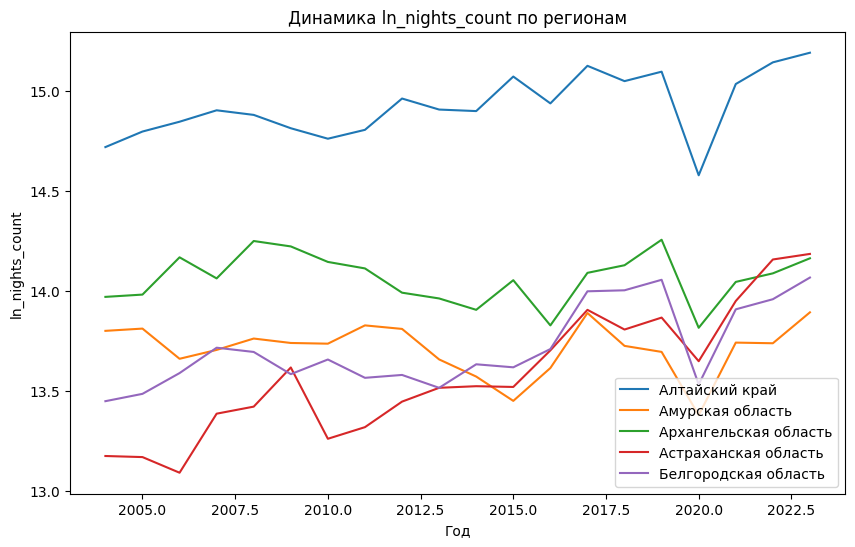

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for region in data_diff_clean.index.get_level_values('region').unique()[:5]:  # Первые 5 регионов
    region_data = data_diff_clean.xs(region, level='region')
    plt.plot(region_data.index, region_data['ln_nights_count'], label=region)
plt.legend()
plt.title('Динамика ln_nights_count по регионам')
plt.xlabel('Год')
plt.ylabel('ln_nights_count')
plt.show()

Размер тренировочной выборки (z < 1.5, 2003–2020): 1279
Размер тестовой выборки (z < 1.5, 2021–2023): 212
Размер тренировочной выборки в первой разности: 1178
Размер тестовой выборки в первой разности: 205

Модель 3: PanelOLS в первой разности без ln_price_adjusted:
                           PanelOLS Estimation Summary                            
Dep. Variable:     ln_nights_count_diff   R-squared:                        0.1893
Estimator:                     PanelOLS   R-squared (Between):             -38.646
No. Observations:                  1178   R-squared (Within):               0.1829
Date:                  Wed, May 28 2025   R-squared (Overall):             -0.7557
Time:                          14:47:52   Log-likelihood                    998.02
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      36.056
Entities:                            74   P-value                    

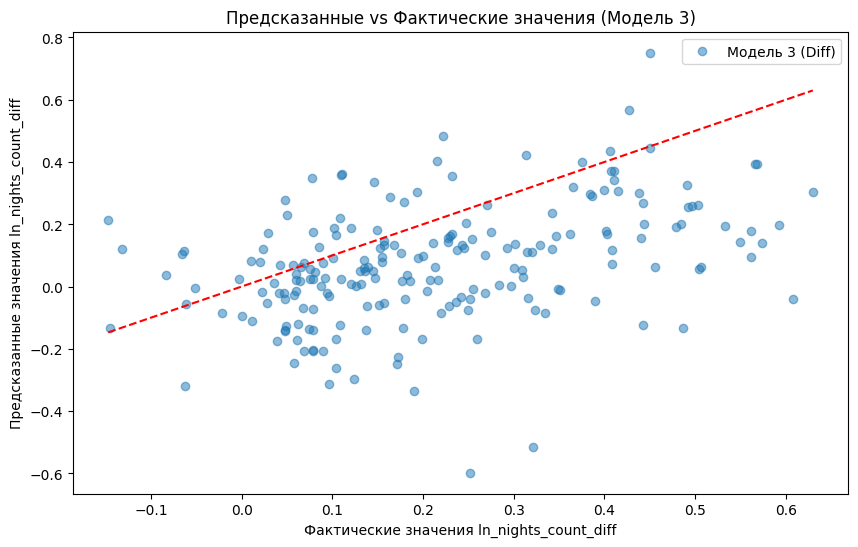

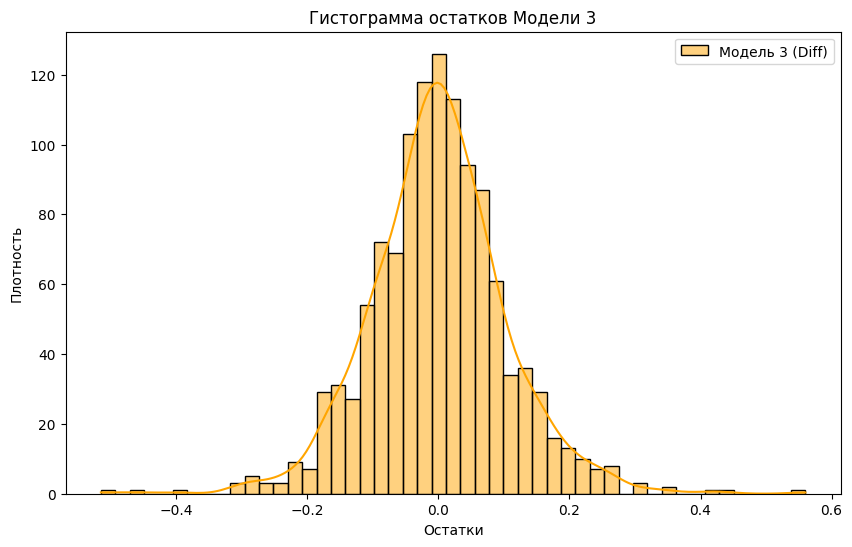

In [42]:
# Импорт библиотек
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Предполагаем, что data_clean уже подготовлена с мультииндексом (region, year)
# Разделение данных (из вашего вывода)
train_data = data_clean[data_clean.index.get_level_values('year') <= 2020].copy()
test_data = data_clean[data_clean.index.get_level_values('year') > 2020].copy()
print(f"Размер тренировочной выборки (z < 1.5, 2003–2020): {len(train_data)}")
print(f"Размер тестовой выборки (z < 1.5, 2021–2023): {len(test_data)}")

# Модель 3: PanelOLS в первой разности без ln_price_adjusted
data_diff = data_clean.sort_values(['region', 'year']).copy()
data_diff['ln_nights_count_diff'] = data_diff.groupby('region')['ln_nights_count'].diff()
data_diff_clean = data_diff.copy()
data_diff_clean = data_diff_clean.dropna(subset=['ln_nights_count_diff'])
z_scores = np.abs(stats.zscore(data_diff_clean['ln_nights_count_diff']))
data_diff_clean = data_diff_clean[z_scores <= 3].copy()

# Разделение на тренировочную и тестовую выборки
train_data_diff = data_diff_clean[data_diff_clean.index.get_level_values('year') <= 2020].copy()
test_data_diff = data_diff_clean[data_diff_clean.index.get_level_values('year') > 2020].copy()
print(f"Размер тренировочной выборки в первой разности: {len(train_data_diff)}")
print(f"Размер тестовой выборки в первой разности: {len(test_data_diff)}")

# Переменные для модели в первой разности
exog_diff = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted',
             'ln_population', 'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
diff_model = PanelOLS(train_data_diff['ln_nights_count_diff'], sm.add_constant(train_data_diff[exog_diff]),
                      entity_effects=True, time_effects=True, drop_absorbed=True)
diff_results = diff_model.fit(cov_type='clustered', cluster_entity=True)
print("\nМодель 3: PanelOLS в первой разности без ln_price_adjusted:")
print(diff_results.summary)

# Предсказания на тестовом наборе
test_exog_diff = sm.add_constant(test_data_diff[exog_diff])
test_pred_diff = diff_results.predict(test_exog_diff)
test_pred_diff = test_pred_diff.iloc[:, 0]
test_pred_diff = pd.Series(test_pred_diff, index=test_data_diff.index)

# Вычисление R²
ss_total_diff = np.sum((test_data_diff['ln_nights_count_diff'] - test_data_diff['ln_nights_count_diff'].mean())**2)
ss_residual_diff = np.sum((test_data_diff['ln_nights_count_diff'] - test_pred_diff)**2)
r2_test_diff = 1 - ss_residual_diff / ss_total_diff
print(f"\nR² на тестовой выборке для Модели 3: {r2_test_diff:.4f}")

# Диагностика остатков
residuals_diff = diff_results.resids

# Тест Шапиро-Уилка
stat_diff, p_diff = stats.shapiro(residuals_diff)
print(f"\nТест Шапиро-Уилка для Модели 3 (Diff): Statistic={stat_diff:.4f}, p-value={p_diff:.4f}")
if p_diff > 0.05:
    print("Остатки распределены нормально (p-value > 0.05).")
else:
    print("Остатки не распределены нормально (p-value <= 0.05).")

# Тест Дарбина-Уотсона
dw_stat_diff = durbin_watson(residuals_diff)
print(f"\nТест Дарбина-Уотсона для Модели 3 (Diff): {dw_stat_diff:.4f}")
if 1.5 <= dw_stat_diff <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2).")
else:
    print("Возможна автокорреляция (значение далеко от 2).")

# Тест Бройша-Пагана
X_diff = sm.add_constant(train_data_diff[exog_diff])
model_ols_diff = sm.OLS(train_data_diff['ln_nights_count_diff'], X_diff).fit()
residuals_ols_diff = model_ols_diff.resid
bp_test_diff = het_breuschpagan(residuals_ols_diff, X_diff)
labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
print("\nТест Бройша-Пагана для Модели 3 (Diff):")
print(dict(zip(labels, bp_test_diff)))
if bp_test_diff[1] < 0.05:
    print("Гетероскедастичность присутствует (p-value < 0.05).")
else:
    print("Гетероскедастичность отсутствует (p-value >= 0.05).")

# Графики
# График предсказанных vs фактических значений
plt.figure(figsize=(10, 6))
plt.scatter(test_data_diff['ln_nights_count_diff'], test_pred_diff, alpha=0.5, label='Модель 3 (Diff)')
plt.plot([test_data_diff['ln_nights_count_diff'].min(), test_data_diff['ln_nights_count_diff'].max()],
         [test_data_diff['ln_nights_count_diff'].min(), test_data_diff['ln_nights_count_diff'].max()],
         color='red', linestyle='--')
plt.xlabel('Фактические значения ln_nights_count_diff')
plt.ylabel('Предсказанные значения ln_nights_count_diff')
plt.title('Предсказанные vs Фактические значения (Модель 3)')
plt.legend()
plt.show()

# Гистограмма остатков
plt.figure(figsize=(10, 6))
sns.histplot(residuals_diff, kde=True, color='orange', alpha=0.5, label='Модель 3 (Diff)')
plt.title('Гистограмма остатков Модели 3')
plt.xlabel('Остатки')
plt.ylabel('Плотность')
plt.legend()
plt.show()

In [47]:
# Импорт библиотек (предполагаем, что они уже импортированы)
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Переменные для модели
exog_vars_fe = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted',
                'ln_population', 'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']

# Убедимся, что exog_fe — это датафрейм с числовыми данными
exog_fe = train_data[exog_vars_fe]

# Проверка типов данных
print("Типы данных в exog_fe:")
print(exog_fe.dtypes)

# Если есть нечисловые столбцы, преобразуем их
exog_fe = exog_fe.astype(float)

# Модель 4: Random Effects (RE)
re_model = RandomEffects(train_data['ln_nights_count'], sm.add_constant(exog_fe))
re_results = re_model.fit(cov_type='clustered', cluster_entity=True)
print("\nМодель 4: Random Effects (RE):")
print(re_results.summary)

# Тест Хаусмана
def hausman_test(fe_results, re_results):
    fe_params = fe_results.params
    re_params = re_results.params
    common_params = fe_params.index.intersection(re_params.index)
    fe_params = fe_params[common_params]
    re_params = re_params[common_params]
    diff = fe_params - re_params
    fe_cov = fe_results.cov.loc[common_params, common_params]
    re_cov = re_results.cov.loc[common_params, common_params]
    cov_diff = fe_cov - re_cov
    hausman_stat = diff.T @ np.linalg.pinv(cov_diff) @ diff
    df = len(common_params)
    p_value = 1 - stats.chi2.cdf(hausman_stat, df)
    return hausman_stat, p_value

# Предполагаем, что fe_results уже есть (из Модели 1)
hausman_stat, hausman_p = hausman_test(fe_results, re_results)
print(f"\nТест Хаусмана: Statistic={hausman_stat:.4f}, p-value={hausman_p:.4f}")
if hausman_p < 0.05:
    print("Фиксированные эффекты предпочтительнее (p-value < 0.05).")
else:
    print("Случайные эффекты приемлемы (p-value >= 0.05).")

Типы данных в exog_fe:
ln_nights_count_lag1          float64
ln_nights_count_lag2          float64
ln_gdp_per_capita_adjusted    float64
ln_population                 float64
ln_unemployment               float64
ln_diesel_price_adjusted      float64
ln_train_cost_adjusted        float64
dtype: object

Модель 4: Random Effects (RE):
                        RandomEffects Estimation Summary                        
Dep. Variable:        ln_nights_count   R-squared:                        0.9035
Estimator:              RandomEffects   R-squared (Between):              0.9815
No. Observations:                1279   R-squared (Within):              -0.4072
Date:                Wed, May 28 2025   R-squared (Overall):              0.9035
Time:                        15:05:38   Log-likelihood                    26.840
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1699.9
Entities:        

In [44]:
# Остатки из Модели 1
residuals_fe = fe_results.resids

# Тест Шапиро-Уилка
stat_fe, p_fe = stats.shapiro(residuals_fe)
print(f"\nТест Шапиро-Уилка для Модели 1 (FE): Statistic={stat_fe:.4f}, p-value={p_fe:.4f}")
if p_fe > 0.05:
    print("Остатки распределены нормально (p-value > 0.05).")
else:
    print("Остатки не распределены нормально (p-value <= 0.05).")

# Тест Дарбина-Уотсона
dw_stat_fe = durbin_watson(residuals_fe)
print(f"\nТест Дарбина-Уотсона для Модели 1 (FE): {dw_stat_fe:.4f}")
if 1.5 <= dw_stat_fe <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2).")
else:
    print("Возможна автокорреляция (значение далеко от 2).")

# Тест Бройша-Пагана
X_fe = sm.add_constant(train_data[exog_fe])
model_ols_fe = sm.OLS(train_data['ln_nights_count'], X_fe).fit()
residuals_ols_fe = model_ols_fe.resid
bp_test_fe = het_breuschpagan(residuals_ols_fe, X_fe)
labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
print("\nТест Бройша-Пагана для Модели 1 (FE):")
print(dict(zip(labels, bp_test_fe)))
if bp_test_fe[1] < 0.05:
    print("Гетероскедастичность присутствует (p-value < 0.05).")
else:
    print("Гетероскедастичность отсутствует (p-value >= 0.05).")


Тест Шапиро-Уилка для Модели 1 (FE): Statistic=0.9641, p-value=0.0000
Остатки не распределены нормально (p-value <= 0.05).

Тест Дарбина-Уотсона для Модели 1 (FE): 1.5074
Автокорреляция отсутствует (значение близко к 2).

Тест Бройша-Пагана для Модели 1 (FE):
{'LM Statistic': np.float64(65.9463389043225), 'LM p-value': np.float64(9.703092386276338e-12), 'F Statistic': np.float64(9.870932628897922), 'F p-value': np.float64(4.910136817086687e-12)}
Гетероскедастичность присутствует (p-value < 0.05).


In [45]:
# Остатки из Модели 2
residuals_2sls = iv_results.resids

# Тест Шапиро-Уилка
stat_2sls, p_2sls = stats.shapiro(residuals_2sls)
print(f"\nТест Шапиро-Уилка для Модели 2 (IV-2SLS): Statistic={stat_2sls:.4f}, p-value={p_2sls:.4f}")
if p_2sls > 0.05:
    print("Остатки распределены нормально (p-value > 0.05).")
else:
    print("Остатки не распределены нормально (p-value <= 0.05).")

# Тест Дарбина-Уотсона
dw_stat_2sls = durbin_watson(residuals_2sls)
print(f"\nТест Дарбина-Уотсона для Модели 2 (IV-2SLS): {dw_stat_2sls:.4f}")
if 1.5 <= dw_stat_2sls <= 2.5:
    print("Автокорреляция отсутствует (значение близко к 2).")
else:
    print("Возможна автокорреляция (значение далеко от 2).")


Тест Шапиро-Уилка для Модели 2 (IV-2SLS): Statistic=0.9654, p-value=0.0000
Остатки не распределены нормально (p-value <= 0.05).

Тест Дарбина-Уотсона для Модели 2 (IV-2SLS): 1.5430
Автокорреляция отсутствует (значение близко к 2).


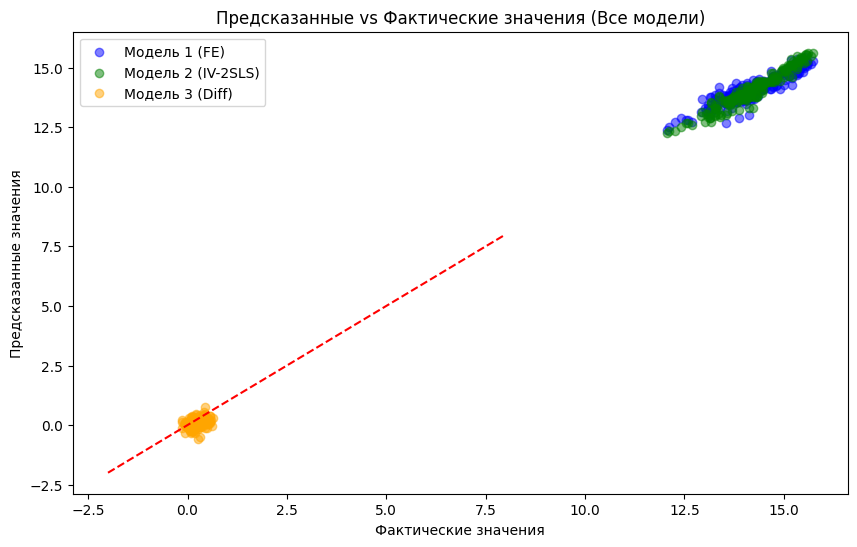

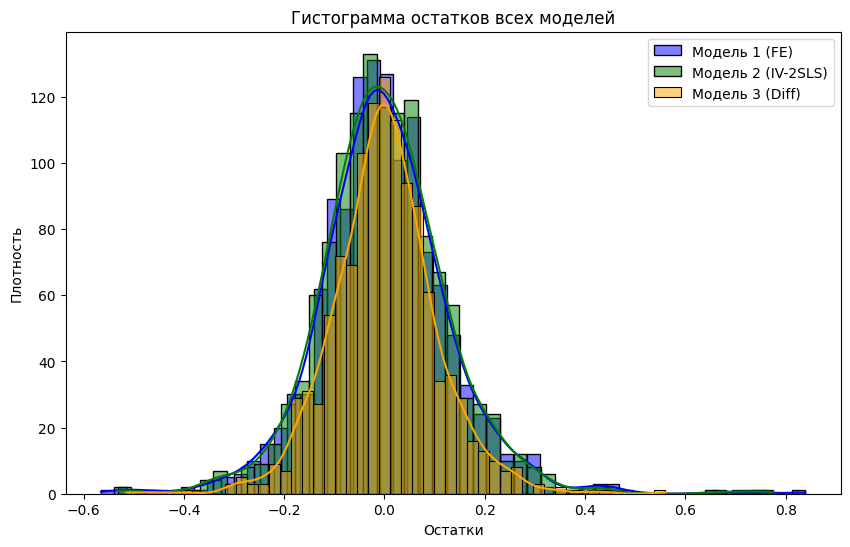

<Figure size 1000x600 with 0 Axes>

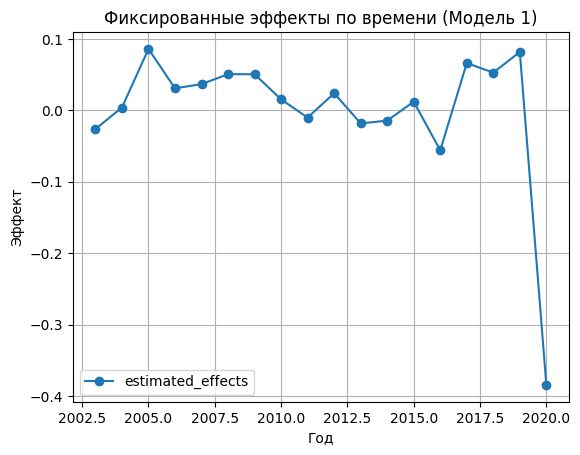

In [46]:
# Предсказания для Модели 1 (FE)
test_exog_fe = sm.add_constant(test_data[exog_fe])
test_pred_fe = fe_results.predict(test_exog_fe)
test_pred_fe = test_pred_fe.iloc[:, 0]
test_pred_fe = pd.Series(test_pred_fe, index=test_data.index)

# Предсказания для Модели 2 (IV-2SLS)
train_data_reset = train_data.reset_index()
test_data_reset = test_data.reset_index()
train_data_dummy = pd.get_dummies(train_data_reset, columns=['region', 'year'], drop_first=True)
test_data_dummy = pd.get_dummies(test_data_reset, columns=['region', 'year'], drop_first=True)
missing_cols = set(train_data_dummy.columns) - set(test_data_dummy.columns)
for col in missing_cols:
    test_data_dummy[col] = 0
test_data_dummy = test_data_dummy[train_data_dummy.columns]
exog_vars_2sls = ['ln_nights_count_lag1', 'ln_nights_count_lag2', 'ln_gdp_per_capita_adjusted',
                  'ln_population', 'ln_unemployment', 'ln_diesel_price_adjusted', 'ln_train_cost_adjusted']
dummy_vars = [col for col in train_data_dummy.columns if col.startswith('region_') or col.startswith('year_')]
test_exog_2sls = test_data_dummy[exog_vars_2sls + dummy_vars]
test_endog_2sls = test_data_dummy['ln_price_adjusted']
test_pred_2sls = iv_results.predict(exog=sm.add_constant(test_exog_2sls), endog=test_endog_2sls)
test_pred_2sls = test_pred_2sls.to_numpy().flatten()

# Предсказания для Модели 3 (Diff)
test_exog_diff = sm.add_constant(test_data_diff[exog_fe])
test_pred_diff = diff_results.predict(test_exog_diff)
test_pred_diff = test_pred_diff.iloc[:, 0]
test_pred_diff = pd.Series(test_pred_diff, index=test_data_diff.index)

# График предсказанных vs фактических значений
plt.figure(figsize=(10, 6))
plt.scatter(test_data['ln_nights_count'], test_pred_fe, alpha=0.5, label='Модель 1 (FE)', color='blue')
plt.scatter(test_data_dummy['ln_nights_count'], test_pred_2sls, alpha=0.5, label='Модель 2 (IV-2SLS)', color='green')
plt.scatter(test_data_diff['ln_nights_count_diff'], test_pred_diff, alpha=0.5, label='Модель 3 (Diff)', color='orange')
plt.plot([-2, 8], [-2, 8], color='red', linestyle='--')  # Диапазон подогнан под ожидаемые значения
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные vs Фактические значения (Все модели)')
plt.legend()
plt.show()

# Гистограмма остатков
plt.figure(figsize=(10, 6))
sns.histplot(fe_results.resids, kde=True, color='blue', alpha=0.5, label='Модель 1 (FE)')
sns.histplot(iv_results.resids, kde=True, color='green', alpha=0.5, label='Модель 2 (IV-2SLS)')
sns.histplot(diff_results.resids, kde=True, color='orange', alpha=0.5, label='Модель 3 (Diff)')
plt.title('Гистограмма остатков всех моделей')
plt.xlabel('Остатки')
plt.ylabel('Плотность')
plt.legend()
plt.show()

# График временных эффектов для Модели 1
time_effects = fe_results.estimated_effects.groupby(level=1).mean()
plt.figure(figsize=(10, 6))
time_effects.plot(kind='line', marker='o')
plt.title('Фиксированные эффекты по времени (Модель 1)')
plt.xlabel('Год')
plt.ylabel('Эффект')
plt.grid(True)
plt.show()